In [ ]:
import torch as torch
import torch.nn as nn
from typing import Optional
from math import floor, log2, sqrt
import torch.nn.functional as F

In [ ]:
class FFFv1(nn.Module):
    def __init__(self, in_dim, out_dim, h_dim, depth, tree_act=nn.LogSigmoid(), topk=None, save_probs=False):
        super().__init__()
        self.save_probs, self.tree_act, self.depth = save_probs, tree_act, depth
        self.n = 2**depth
        self.topk = topk or self.n
        def uniform(shape, scale): 
            return nn.Parameter(torch.empty(shape).uniform_(-scale,scale))
        self.nodes = uniform((self.n-1, in_dim), scale=1/sqrt(in_dim))
        self.w1 = uniform((self.n, h_dim, in_dim), scale=1/sqrt(in_dim))
        self.w2 = uniform((self.n, out_dim, h_dim), scale=1/sqrt(h_dim))
        self.act = nn.ReLU()
        self.t, self.s = self.init_t_(), self.init_s_()

    def init_t_(self):
        tree, res = torch.eye(self.n), []
        for _ in range(self.depth): 
            res.append(tree)
            tree = tree.view(self.n, -1, 2).sum(-1)
        return nn.Parameter(torch.cat(list(reversed(res)),dim=1), False)

    def init_s_(self):
        s = torch.eye(self.n-1)
        return nn.Parameter(torch.stack([s,-s], dim=2).view(self.n-1,2*(self.n-1)), False)

    def forward(self, x):
        bs = x.shape[0]
        if self.training:
            z = x.matmul(self.nodes.T).matmul(self.s)
            z = self.tree_act(z).matmul(self.t.T)
            if self.save_probs: self.probs = torch.softmax(z,-1)
            probs, indices = z.topk(self.topk)
            probs = torch.softmax(probs, dim=-1)
        else:
            indices = torch.zeros(bs, dtype=torch.long, device=x.device)
            for _ in range(self.depth):
                indices = indices*2 + 1 + (torch.einsum("b i, b i -> b", x, self.nodes[indices])<0).long()
            indices = indices[:,None] - self.n+1
            probs = torch.ones(bs,1)
        x = torch.einsum('bx, bkyx -> bky', x, self.w1[indices])
        x = torch.einsum('bkx, bkyx -> bky', self.act(x), self.w2[indices])
        return torch.einsum('bky, bk -> by', x, probs) if probs.shape[1]>1 else x[:,0]

In [ ]:
INIT_STRAT = 'uniform'

class FFFv2(nn.Module):
    def __init__(self, nIn: int, nOut: int, depth: Optional[int] = None):
        super().__init__()
        self.depth = depth or int(floor(log2(nIn)))  # depth is the number of decision boundaries
        nNodes = 2 ** self.depth - 1

        if INIT_STRAT == 'uniform':
            # This from orig authors; scaling looks off for self.Y
            def create_basis_vectors_of(length, scaling):
                return nn.Parameter(torch.empty(nNodes, length).uniform_(-scaling, scaling))
            self.X = create_basis_vectors_of(length=nIn, scaling=1/sqrt(nIn))
            self.Y = create_basis_vectors_of(length=nOut, scaling=1/sqrt(self.depth + 1))

        elif INIT_STRAT == 'hyperspherical-shell':
            # Initialize vectors on INPUT/OUTPUT space unit hypersphere
            #   (idea: basis vectors should be of unit length).
            def create_random_unit_vectors_of(length):
                weights = torch.randn(nNodes, length)  # Initialize weights randomly
                weights = F.normalize(weights, p=2, dim=-1)  # L2-Normalize along the last dimension
                return nn.Parameter(weights)
            self.X = create_random_unit_vectors_of(length=nIn)
            self.Y = create_random_unit_vectors_of(length=nOut)

    def forward(self, x: torch.Tensor):
        nBatch, nIn, nOut = x.shape[0], self.X.shape[-1], self.Y.shape[-1]
        current_node = torch.zeros(nBatch, dtype=torch.long, device=x.device)

        # Walk the tree, assembling y piecemeal
        y = torch.zeros((nBatch, nOut), dtype=torch.float, device=x.device)
        for _ in range(self.depth):
            λ = torch.einsum("b i, b i -> b", x, self.X[current_node])
            y += torch.einsum("b, b j -> b j", λ, self.Y[current_node])
            branch_choice = (λ > 0).long()
            current_node = (current_node * 2) + 1 + branch_choice
        return y

    def __repr__(self):
        return f"FFF({self.X.shape[-1]}, {self.Y.shape[-1]}, depth={self.depth})"

epoch,train_loss,valid_loss,accuracy,time
0,0.888499,0.828826,0.705800,00:10
1,0.400913,0.560025,0.853600,00:14
2,0.302955,0.571529,0.851000,00:12
3,0.254399,0.483818,0.865800,00:11
4,0.223843,0.471395,0.874800,00:12


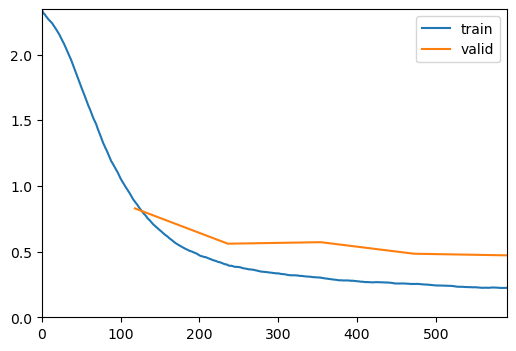

In [ ]:
from fastai.callback.wandb import *
from FastFF.utils import *
from fastai.vision.all import *

bs = 512
params = dict(
    in_dim=28*28,
    out_dim=10,
    h_dim=3,
    depth=3,
    topk=2)

fff = FFFv1(**params)
cbs = [ShowGraphCallback()]
dls = get_mnist_dls(bs)
Learner(dls, fff, loss_func=F.cross_entropy, metrics=accuracy, cbs=cbs).fit_one_cycle(5, lr_max=7e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.219669,0.937554,0.690500,00:11
1,0.722023,0.622621,0.806200,00:11
2,0.642424,0.650940,0.798600,00:10
3,0.603538,0.619926,0.811100,00:10
4,0.596412,0.609798,0.819200,00:11


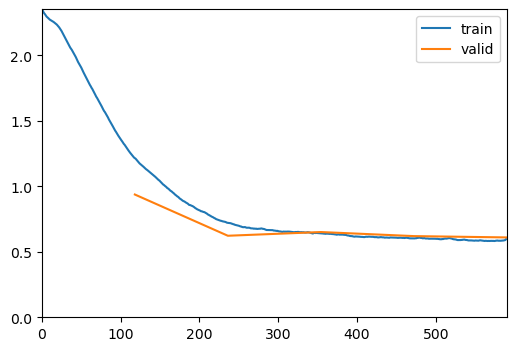

In [ ]:
bs = 512
params = dict(
    nIn=28*28,
    nOut=10,
    depth=3)

fff = FFFv2(**params)
cbs = [ShowGraphCallback()]
dls = get_mnist_dls(bs)
Learner(dls, fff, loss_func=F.cross_entropy, metrics=accuracy, cbs=cbs).fit_one_cycle(5, lr_max=7e-3)

In [ ]:
from torch.utils import benchmark

def benchmark_model(model, x, cuda=False):
    if cuda: model,x = model.cuda(), x.cuda()
    return benchmark.Timer(
            stmt='model(x)',
            globals=locals(),
            label=model._get_name(),
            description='time',
        ).blocked_autorange(min_run_time=0.2)

def benchmark_with_params(func, x, params: list, cuda=False):
    '''func must accept single parameter from params and return model for `benchmark_model`'''
    results= L((benchmark_model(func(p), x, cuda)) for p in progress_bar(params, parent=globals().get('mb',None)))
    # take mean and convert to ms
    return results.map(lambda x: x.mean*1e3)

# CPU

In [ ]:
params = dict(
    in_dim=28*28,
    out_dim=10,
    h_dim=1,
    depth=1,
    topk=2)

def get_model(d):
    params['depth']=params['h_dim']=d
    return FFFv1(**params).eval()

depths = [1,2,3,4,5,6,7,8]

x = dls.one_batch()[0]

res1 = benchmark_with_params(get_model, x,  depths)

In [ ]:
params = dict(
    nIn=28*28,
    nOut=10)

res2 = benchmark_with_params(lambda d: FFFv2(depth=d,**params), x,  depths)

<matplotlib.legend.Legend>

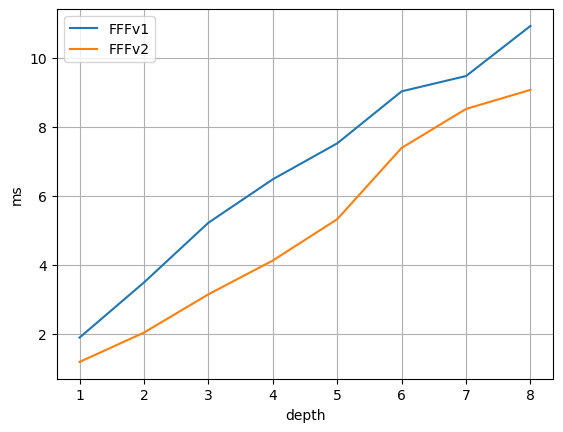

In [ ]:
import matplotlib.pyplot as plt

plt.plot(depths, res1, label = 'FFFv1')
plt.plot(depths, res2, label = 'FFFv2')
plt.ylabel('ms')
plt.xlabel('depth')
plt.grid()
plt.legend()

## CUDA

In [ ]:
params = dict(
    in_dim=28*28,
    out_dim=10,
    h_dim=1,
    depth=1,
    topk=2)

res1 = benchmark_with_params(get_model, x,  depths, cuda=True)

In [ ]:
params = dict(
    nIn=28*28,
    nOut=10)

res2 = benchmark_with_params(lambda d: FFFv2(depth=d,**params), x,  depths, cuda=True)

<matplotlib.legend.Legend>

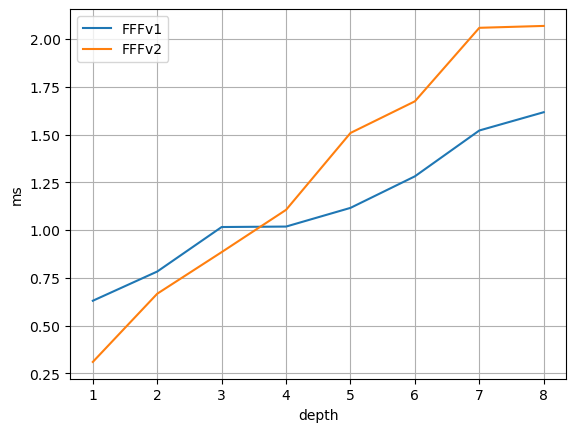

In [ ]:
plt.plot(depths, res1, label = 'FFFv1')
plt.plot(depths, res2, label = 'FFFv2')
plt.ylabel('ms')
plt.xlabel('depth')
plt.grid()
plt.legend()